# Import necessary libraries


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error


from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

2024-03-13 12:18:24.401128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 12:18:24.401249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 12:18:24.649638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the dataset


In [ ]:
# Load the dataset
file_path = '/kaggle/input/time-series-classification-part-1/ETTh1_without_missing.csv'
data = pd.read_csv(file_path)

# Parse the 'date' column as datetime
data['date'] = pd.to_datetime(data['date'])

# Set the 'date' column as the index
data.set_index('date', inplace=True)

# Drop unnecessary columns
data.drop(['Id', 'Unnamed: 3'], axis=1, inplace=True)
data.describe()

,OT
count,17320.000000
mean,13.352560
std,8.582739
min,-4.080000
25%,6.964000
50%,11.467000
75%,18.150000
max,46.007000


# Analyzing the dataset

In [ ]:
# Analyse de la stationnarité de la variable
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(data)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -3.435036944115833        |
| P-valeur       | 0.009820898067884347      |
| Conclusion     | La série est stationnaire |


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


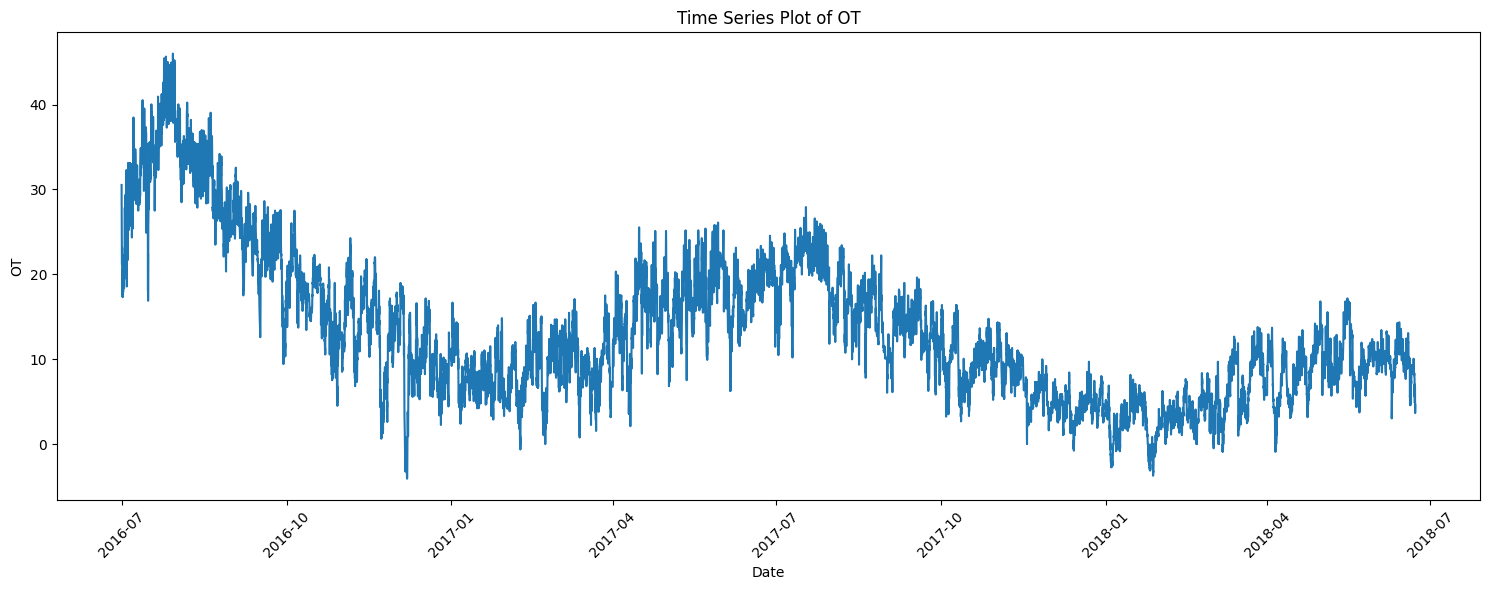

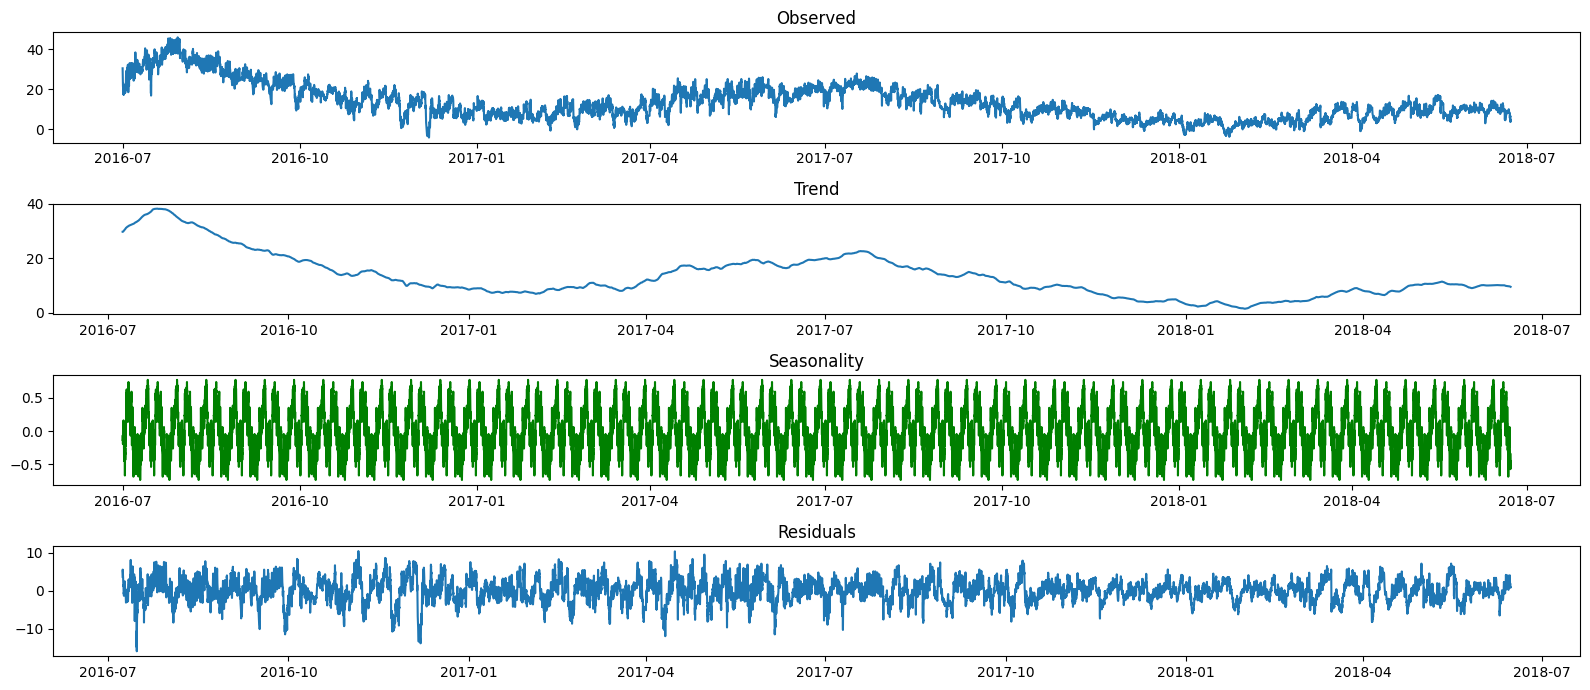

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Plot the 'OT' time series
plt.figure(figsize=(15, 6))
sns.lineplot(x=data.index, y=data['OT'])
plt.title('Time Series Plot of OT')
plt.xlabel('Date')
plt.ylabel('OT')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Decompose the time series to analyze trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the frequency is daily for now, we might need to adjust this based on the actual data frequency
decomposition = seasonal_decompose(data['OT'].dropna(), model='additive', period=365)

plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal,color='green')
plt.title('Seasonality')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals')
plt.tight_layout()
plt.show()

# Preprocessing the dataset

In [ ]:
# Only keep values from october onwards to minimize seasonality
df=data.iloc[1700:]

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler()
df['OT_normalized'] = scaler.fit_transform(df[['OT']])

/tmp/ipykernel_26/1806319736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OT_normalized'] = scaler.fit_transform(df[['OT']])


In [ ]:
df.tail(100)

,OT,OT_normalized
date,,
2018-06-18 12:00:00,10.833,0.455902
2018-06-18 13:00:00,11.185,0.466663
2018-06-18 14:00:00,11.959,0.490324
2018-06-18 15:00:00,13.085,0.524747
2018-06-18 16:00:00,11.959,0.490324
...,...,...
2018-06-22 11:00:00,6.753,0.331173
2018-06-22 12:00:00,3.658,0.236557
2018-06-22 13:00:00,3.658,0.236557


# Model initialization

In [ ]:
# Function to create sequences from the time series data
def create_sequences(input_data, window_size):
    X = []
    Y = []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:(i + window_size), 0])
        Y.append(input_data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Prepare sequences using the normalized 'OT' values
window_size = 10
X, Y = create_sequences(df[['OT_normalized']].values, window_size)

In [ ]:
# Split the data into training and test sets (excluding the last 100 values for testing)
X_train = X[:-100]
Y_train = Y[:-100]
X_test = X[-100:]
Y_test = Y[-100:]

In [ ]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [ ]:
from tensorflow.keras.layers import Dropout

# Build the LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(window_size, 1)), # 'window_size' and the last dimension '1' should match your data shape
    Dropout(0.2),  # Dropout layer after the first LSTM layer
    LSTM(128,activation='relu'),  # Second LSTM layer, could adjust the number of units
    Dropout(0.2),  # Dropout layer after the second LSTM layer
    Dense(1)  # Output layer that predicts the future value
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [ ]:
# (Optional) Print model summary to verify architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

# Model evaluation and training

In [ ]:
# After training, evaluate the model
model.evaluate(X_test, Y_test)

1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1803 - root_mean_squared_error: 0.4246

I0000 00:00:1710332328.705560      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.1517 - root_mean_squared_error: 0.3990


[0.13202257454395294, 0.38884371519088745]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1  #Set verbose to 1 or 2 to see the training progress
)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual Y_test values to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Prepare data for plotting
preds = predictions_inverse.flatten()
actuals = Y_test_inverse.flatten()

(preds[:10], actuals[:10])  # Display the first 10 predictions and actual values for comparison


Epoch 1/60
 26/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1458 - root_mean_squared_error: 0.3726

W0000 00:00:1710332336.369320      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0390 - root_mean_squared_error: 0.1786 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 2/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 9.6122e-04 - val_root_mean_squared_error: 0.0313
Epoch 3/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 4/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 5/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 8.7212e-04 - val_root_mean_squared_error: 0.0298
Epoch 6/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 7.9213e-04 - val_root_mean_squared_error: 0.0285
Epoch 7/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

(array([10.23812 , 11.182235, 11.483803, 12.306612, 13.482448, 12.043382,
        12.074331, 11.737752, 11.535384, 10.554946], dtype=float32),
 array([10.83300018, 11.18500042, 11.95899963, 13.08500004, 11.95899963,
        12.02900028, 12.02900028, 11.81799984, 10.62199974, 10.19999981]))

In [ ]:
test_dates = df.index[-100:]  # Assuming 'df' has 'date' set as its index

# Create a DataFrame for comparing predictions with actual values
comparison_df = pd.DataFrame({
    'date': test_dates,
    'Actual': actuals,  # 'actuals' needs to be defined previously
    'Predicted': preds  # 'preds' needs to be defined previously
})

# Display the DataFrame
comparison_df

,date,Actual,Predicted
0,2018-06-18 12:00:00,10.833,10.238120
1,2018-06-18 13:00:00,11.185,11.182235
2,2018-06-18 14:00:00,11.959,11.483803
3,2018-06-18 15:00:00,13.085,12.306612
4,2018-06-18 16:00:00,11.959,13.482448
...,...,...,...
95,2018-06-22 11:00:00,6.753,6.612801
96,2018-06-22 12:00:00,3.658,6.937288
97,2018-06-22 13:00:00,3.658,4.674125
98,2018-06-22 14:00:00,4.150,4.221718


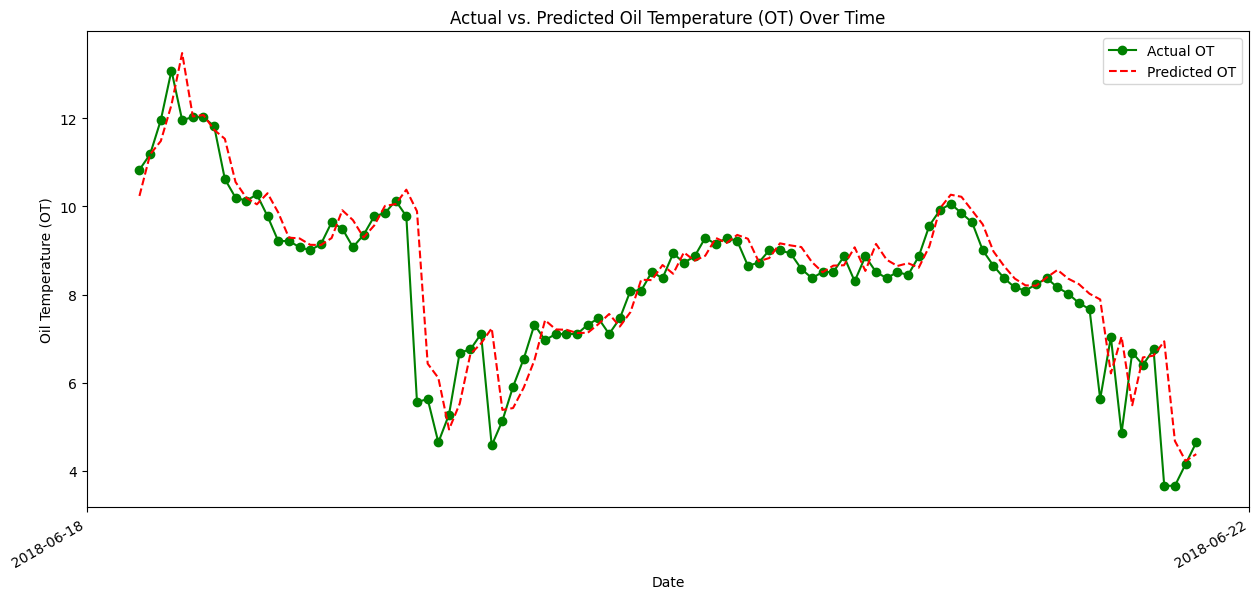

In [ ]:
# Sample DataFrame 'comparison_df' columns: 'Date', 'Actual', 'Predicted'
# Ensure 'Date' is in datetime format; if not, convert it
comparison_df['date'] = pd.to_datetime(comparison_df['date'])

# Plotting
plt.figure(figsize=(15, 7))  # Set the figure size for better readability
plt.plot(comparison_df['date'], comparison_df['Actual'], label='Actual OT', color='green', marker='o')
plt.plot(comparison_df['date'], comparison_df['Predicted'], label='Predicted OT', color='red', linestyle='--')

# Formatting the plot
plt.title('Actual vs. Predicted Oil Temperature (OT) Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Adjust interval for better readability
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

In [ ]:
mae = mean_absolute_error(actuals, preds)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.47895107269287096


# Forecasting

In [ ]:
# Function to make future predictions, returning both the scaled and original values
def make_future_predictions(model, scaler, last_window, future_steps=100):
    future_preds_scaled = []
    current_step = last_window

    for _ in range(future_steps):
        # Predict the next step
        next_step_pred = model.predict(current_step.reshape((1, window_size, 1)))
        future_preds_scaled.append(next_step_pred.flatten()[0])

        # Update the current step to include the prediction
        current_step = np.roll(current_step, -1, axis=0)
        current_step[-1] = next_step_pred

    # Inverse transform to get predictions back to their original scale
    future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

    return future_preds

# Assuming df['OT_normalized'] and scaler are already defined
window_size = 10  # This should match the window_size used during training
last_window = df['OT_normalized'].values[-window_size:]

# Generate the next 100 future predictions
future_predictions = make_future_predictions(model, scaler, last_window, future_steps=100)

# Create a DataFrame for the predictions with an ID column starting at 0
future_df = pd.DataFrame({
    'Id': range(0, 100),  # Generate IDs from 0 to 99
    'OT': future_predictions
})

# Display the first few rows to verify
print(future_df.head())

# Save the future predictions to a CSV file
future_df.to_csv('future_ot_predictions.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_26/4029590569.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_step[-1] = next_step_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━